#  Imports

In [94]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
from IPython.display import display, Image as IPImage
import shutil
import requests
from io import BytesIO

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Rescaling, Input, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow.keras.layers as layers
import tensorflow.keras.applications.resnet50 as resnet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
csv_path = os.path.join(parent_directory, "raw_data/computer_vision/pokemon.csv")
df = pd.read_csv(csv_path)


In [3]:
images_directory = os.path.join(parent_directory, "raw_data/computer_vision/images/")


# Exploration

In [4]:
df.head()


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [5]:
images_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/images/'

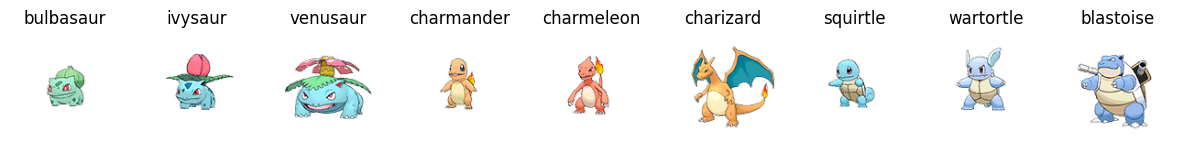

In [6]:
fig, axes = plt.subplots(1, 9, figsize=(15, 5))

for i, nom_pokemon in enumerate(df['Name'].head(9)):
    chemin_image_png = images_directory + nom_pokemon.lower() + ".png"
    chemin_image_jpg = images_directory + nom_pokemon.lower() + ".jpg"

    if os.path.exists(chemin_image_png):
        chemin_image = chemin_image_png
    elif os.path.exists(chemin_image_jpg):
        chemin_image = chemin_image_jpg
    else:
        print(f"Aucun fichier trouvé pour {nom_pokemon}")
        continue

    img = Image.open(chemin_image)

    axes[i].imshow(img)
    axes[i].set_title(nom_pokemon)
    axes[i].axis('off')

plt.show()


# Import OHE

In [7]:
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [8]:
df = df.copy()
df = df.fillna('')
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,
4,charmeleon,Fire,
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,
807,meltan,Steel,


In [9]:
X = df['Type1']

In [10]:
# Use column transform for preprocessing only type1 and type2
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Type1', 'Type2'])
    ],
    remainder='passthrough'
)

In [11]:
# Use a pipelin for look perfectly the step
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Type1', 'Type2'])]))])

In [12]:
# Apply the ohe
df_ohe = pipeline.fit_transform(df[['Type1', 'Type2']])

/home/morgane/.pyenv/versions/3.10.6/envs/catchemall/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
feature_names_out = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['Type1', 'Type2'])

In [14]:
onehot_df = pd.DataFrame(df_ohe, columns=feature_names_out)

In [15]:
onehot_df

,Type1_Dark,Type1_Dragon,Type1_Electric,Type1_Fairy,Type1_Fighting,Type1_Fire,Type1_Flying,Type1_Ghost,Type1_Grass,Type1_Ground,...,Type2_Ghost,Type2_Grass,Type2_Ground,Type2_Ice,Type2_Normal,Type2_Poison,Type2_Psychic,Type2_Rock,Type2_Steel,Type2_Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Delet the prefixe Type_1 and Type_2 for every columns

for col in onehot_df.columns:
    if col.startswith('Type1_'):
        onehot_df.rename(columns={col: col.replace('Type1_', '')}, inplace=True)
    elif col.startswith('Type2_'):
        onehot_df.rename(columns={col: col.replace('Type2_', '')}, inplace=True)
onehot_df

,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
merged_df = onehot_df.groupby(level=0, axis=1).sum()

In [18]:
df_ohe = pd.concat([df, merged_df], axis=1)

In [19]:
df_ohe = df_ohe.drop(['Type1', 'Type2'], axis=1)

In [20]:
df_ohe

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,charmander,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
805,blacephalon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,zeraora,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,meltan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Création dossiers par type de Pokémon

In [21]:
types = set(df['Type1'])
types


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [22]:
parent_directory


'/home/morgane/code/mtthibault/catchemall'

In [23]:
types_directory = os.path.join(parent_directory, "raw_data/computer_vision/types/")
types_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types/'

In [24]:
for pokemon_type in types:
    type_directory_path = os.path.join(types_directory, pokemon_type)
    # Pour vérifier si dossier existe déjà, sinon créer
    if not os.path.exists(type_directory_path):
        os.makedirs(type_directory_path)


# Rangement des pokémons par dossier Type

In [25]:
# for index, row in df.iterrows():
#     pokemon_name = row['Name']
#     type1 = row['Type1']
#     type2 = str(row['Type2'])  # str pcq sinon ça bug à cause des NaN

#     type1_directory_path = os.path.join(types_directory, type1)
#     if os.path.exists(type1_directory_path):
#         for ext in ['jpg', 'png']:
#             source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#             if os.path.exists(source_image_path):
#                 destination_path = os.path.join(type1_directory_path, f'{pokemon_name}.{ext}')
#                 shutil.copy(source_image_path, destination_path)
#                 break

#     # Vérifier si le type 2 existe et copier l'image
#     if type2:
#         type2_directory_path = os.path.join(types_directory, type2)
#         if os.path.exists(type2_directory_path):
#             for ext in ['jpg', 'png']:
#                 source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#                 if os.path.exists(source_image_path):
#                     destination_path = os.path.join(type2_directory_path, f'{pokemon_name}.{ext}')
#                     shutil.copy(source_image_path, destination_path)
#                     break


# Exploration 2

In [26]:
types_path = '/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'
types_path


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

In [27]:
pokemon_dict = {}


In [28]:
os.listdir(types_path)


['Ghost',
 'Fighting',
 'Ground',
 'Dark',
 'Flying',
 'Normal',
 'Steel',
 'Grass',
 'Ice',
 'Rock',
 'Water',
 'Electric',
 'Psychic',
 'Bug',
 'Fairy',
 'Fire',
 'Poison',
 'Dragon']

In [29]:
for type_folder in os.listdir(types_path):
    type_folder_path = os.path.join(types_path, type_folder) #donc là j'ai le chemin pour chaqun de mes folders TYPE

    # vérifie si le chemin est un dossier
    if os.path.isdir(type_folder_path):
        pokemon_names = [] # Jstock les noms des pokémons pour le type actuel

        # parcours de chaque image dans le dossier du type actuel
        for file_name in os.listdir(type_folder_path):
            # pour gérer png jpg
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                pokemon_name = os.path.splitext(file_name)[0] #pour split l'extension .png .jpg cimer chatgpt
                pokemon_names.append(pokemon_name) #J'ajoute le nom du pokémon à la liste

        pokemon_dict[type_folder] = pokemon_names


In [30]:
pokemon_dict


{'Ghost': ['Dusknoir_29091',
  'Shuppet_23440',
  'Misdreavus_14867',
  'Sableye_20798',
  'Honedge_34316',
  'Dusclops_23606',
  'Shedinja_20325',
  'Shedinja_20306',
  'Litwick_32699',
  'Lampent_32721',
  'Lampent_32731',
  'Cofagrigus_31543',
  'Jellicent_32358',
  'Haunter_7147',
  'Duskull_23529',
  'Chandelure_32756',
  'Jellicent_32355',
  'Spiritomb_27565',
  'Misdreavus_14887',
  'Gengar_7177',
  'Gengar_7178',
  'Jellicent_32334',
  'Shedinja_20321',
  'Shuppet_23427',
  'Banette_23504',
  'Rotom_29176',
  'Spiritomb_27578',
  'Duskull_23558',
  'Misdreavus_14852',
  'golett',
  'Dusclops_23612',
  'Phantump_34822',
  'Froslass_29165',
  'Frillish_32306',
  'Haunter_7157',
  'Palossand_35661',
  'Drifloon_26829',
  'Shuppet_23445',
  'Froslass_29162',
  'Spiritomb_27556',
  'Jellicent_32342',
  'Misdreavus_14886',
  'Shedinja_20329',
  'Gastly_7039',
  'Trevenant_34845',
  'Gastly_7074',
  'Mismagius_27018',
  'Misdreavus_14900',
  'Misdreavus_14899',
  'Froslass_29151',
  '

In [31]:
len(pokemon_dict['Bug'])


3318

In [32]:
pokemon_names

['Fraxure_32800',
 'Dratini_11336',
 'axew',
 'Kingdra_16893',
 'Gible_27624',
 'Sliggoo_34770',
 'salamence',
 'Dialga_29375',
 'guzzlord',
 'Dragonair_11403',
 'Latios_24935',
 'Tyrantrum_34609',
 'Axew_32762',
 'Flygon_22235',
 'Dragonite_11506',
 'Haxorus_32811',
 'shelgon',
 'Flygon_22237',
 'Noibat_34919',
 'Dragonair_11426',
 'Goodra_34791',
 'Dragonair_11436',
 'Rayquaza_25084',
 'Dratini_11291',
 'Tyrantrum_34596',
 'Altaria_22449',
 'Salamence_24489',
 'Dragonite_11511',
 'Noibat_34931',
 'goodra',
 'Dialga_29360',
 'dragonite',
 'Bagon_24420',
 'Altaria_22461',
 'Garchomp_27686',
 'Garchomp_27715',
 'Sliggoo_34763',
 'Gible_27597',
 'Shelgon_24450',
 'Fraxure_32799',
 'Bagon_24406',
 'Gible_27587',
 'Dragonair_11381',
 'Gabite_27627',
 'Zweilous_33403',
 'Rayquaza_25080',
 'Sliggoo_34755',
 'Gible_27602',
 'Bagon_24376',
 'Flygon_22240',
 'Zekrom_33688',
 'Latias_24883',
 'Bagon_24384',
 'Axew_32782',
 'Altaria_22470',
 'haxorus',
 'Kyurem_33771',
 'Salamence_24512',
 'Goomy

Type: Ghost


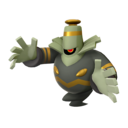

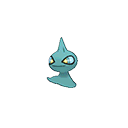

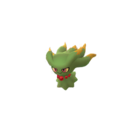



Type: Fighting


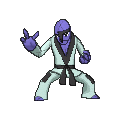

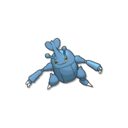

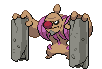



Type: Ground


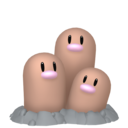

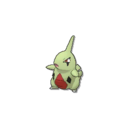

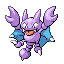



Type: Dark


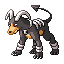

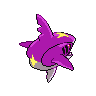

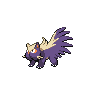



Type: Flying


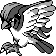

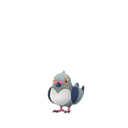

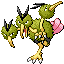



Type: Normal


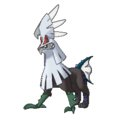

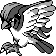

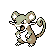



Type: Steel


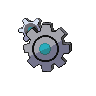

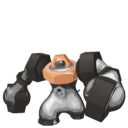

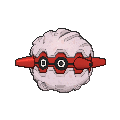



Type: Grass


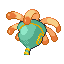

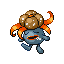

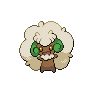



Type: Ice


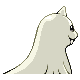

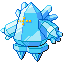

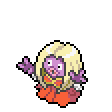



Type: Rock


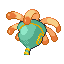

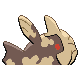

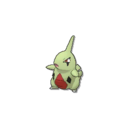



Type: Water


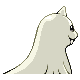

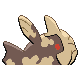

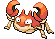



Type: Electric


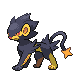

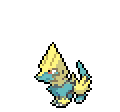

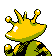



Type: Psychic


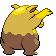

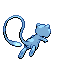

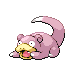



Type: Bug


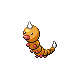

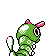

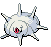



Type: Fairy


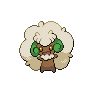

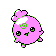

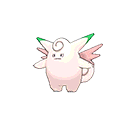



Type: Fire


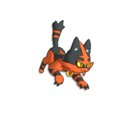

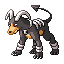

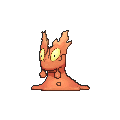



Type: Poison


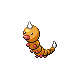

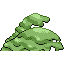

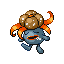



Type: Dragon


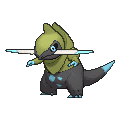

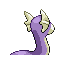

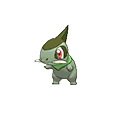

In [33]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                display(IPImage(filename=image_path))
                break
    
    print("\n")

# Analyse

In [34]:
y = list(df['Type1'].unique())
y

['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

In [35]:
types_path

'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

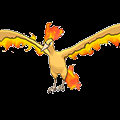

In [36]:
img = load_img(f"{types_path}/Fire/moltres.png")
img

In [37]:
x = img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [38]:
x.shape

(120, 120, 3)

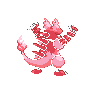

In [39]:
img = load_img(f"{types_path}/Fire/Magmar_9657.png")
img

In [40]:
x = img_to_array(img)
x.shape

(96, 96, 3)

# Models

## Train/Test

In [41]:
train_data_dir = parent_directory + "/raw_data/computer_vision/train_test/train/"
test_data_dir = parent_directory + "/raw_data/computer_vision/train_test/test/"
print(train_data_dir)
print(test_data_dir)

/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/train/
/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/test/


In [42]:
target_size = (120, 120)

def resize_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.LANCZOS)

    # Forcer le mode de l'image à rester en RGB sinon kk
    img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

    img.close()
    return img_array

def resize_images_in_directory(directory):
    # Parcourir les sous-dossiers
    for poketype_folder in os.listdir(directory):
        poketype_folder_path = os.path.join(directory, poketype_folder)

        if os.path.isdir(poketype_folder_path):
            # pour suivre que ya rien qui crash
            print(f"Redimensionnement des images dans le dossier {poketype_folder}...")

            # Créer un sous-dossier 'resized' pour sauvegarder les images redimensionnées
            resized_folder_path = os.path.join(poketype_folder_path, 'resized')
            os.makedirs(resized_folder_path, exist_ok=True)

            # Parcourir les images dans le dossier de chaque type
            image_files = [f for f in os.listdir(poketype_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for image_file in image_files:
                image_path = os.path.join(poketype_folder_path, image_file)

                try:
                    resized_image_array = resize_image(image_path)

                    rescale_layer = Rescaling(scale=1./255)
                    resized_image_array = rescale_layer(np.expand_dims(resized_image_array, axis=0))[0]

                    save_path = os.path.join(resized_folder_path, image_file)
                    array_to_img(resized_image_array).save(save_path)
                except ValueError as e:
                    print(f"Ignoré l'image {image_file} dans le dossier {poketype_folder} : {e}") # ignorer sinon crash
                    continue

In [43]:
# resize_images_in_directory(train_data_dir)

In [44]:
# resize_images_in_directory(test_data_dir)

In [45]:
# x.shape

In [46]:
train_ds = image_dataset_from_directory(train_data_dir,
                                        labels="inferred",
                                        label_mode="categorical",
                                        image_size=(120,120),
                                        batch_size=32,
                                        seed=123)

train_ds

Found 42500 files belonging to 18 classes.


2023-12-09 20:08:14.874031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-09 20:08:14.874264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [47]:
val_ds = image_dataset_from_directory(test_data_dir,
                                      labels="inferred",
                                      label_mode="categorical",
                                      image_size=(120,120),
                                      batch_size=32,
                                      seed=123)

val_ds

Found 10635 files belonging to 18 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [48]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # LOSS
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].legend()
    ax[0].grid()
    
    # ACCURACY
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[1].legend()
    ax[1].grid()

In [49]:
def plot_loss_accuracy(history):

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ## Plot Losses and Accuracies
    x_axis = np.arange(len(history.history['loss']))

    ax[0].set_title("Loss")
    ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
    ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

    ax[1].set_title("Accuracy")
    ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
    ax[1].plot(x_axis,
               history.history['val_accuracy'],
               color="orange",
               linestyle="-",
               marker="X",
               label="Val Accuracy")

    ## Customization
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)
    ax[0].legend()

    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)
    ax[1].legend()


    plt.show()

## CNN (09/12/2023)

### VGG16 V1

In [51]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom((0.1, 0.2)))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

vgg16 = VGG16(weights = "imagenet",
              include_top = False,
              input_shape = (120, 120, 3))

vgg16.trainable = False

my_dense_layers = models.Sequential()

my_dense_layers.add(layers.Dense(64, activation="relu"))
my_dense_layers.add(layers.Dropout(rate=0.5))

predictive_layer = layers.Dense(18, activation="softmax")

In [52]:
def initialize_model():
    inputs = layers.Input(shape = (120, 120, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = vgg16(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.BatchNormalization()(x)

    pred = layers.Dense(18, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=pred)

    return model

In [53]:
model = initialize_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 120, 120, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 120, 120, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 120, 120, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0     

In [54]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [55]:
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.95 ** epoch)

early_stopper = callbacks.EarlyStopping(
    patience=10,
    monitor="val_loss",
    restore_best_weights=True
)

In [56]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopper, lr_scheduler]
)

Epoch 1/50
1329/1329 [==============================] - 516s 388ms/step - loss: 2.8792 - accuracy: 0.1196 - val_loss: 2.5979 - val_accuracy: 0.1932 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 522s 393ms/step - loss: 2.6416 - accuracy: 0.1765 - val_loss: 2.4866 - val_accuracy: 0.2178 - lr: 9.5000e-04
Epoch 3/50
1329/1329 [==============================] - 521s 392ms/step - loss: 2.5553 - accuracy: 0.1959 - val_loss: 2.3874 - val_accuracy: 0.2478 - lr: 9.0250e-04
Epoch 4/50
1329/1329 [==============================] - 522s 393ms/step - loss: 2.4873 - accuracy: 0.2200 - val_loss: 2.3166 - val_accuracy: 0.2598 - lr: 8.5737e-04
Epoch 5/50
1329/1329 [==============================] - 523s 393ms/step - loss: 2.4315 - accuracy: 0.2370 - val_loss: 2.2511 - val_accuracy: 0.2811 - lr: 8.1451e-04
Epoch 6/50
1329/1329 [==============================] - 522s 393ms/step - loss: 2.3879 - accuracy: 0.2450 - val_loss: 2.2094 - val_accuracy: 0.2916 - lr: 7.7378e-04
Epoch 7/50
132

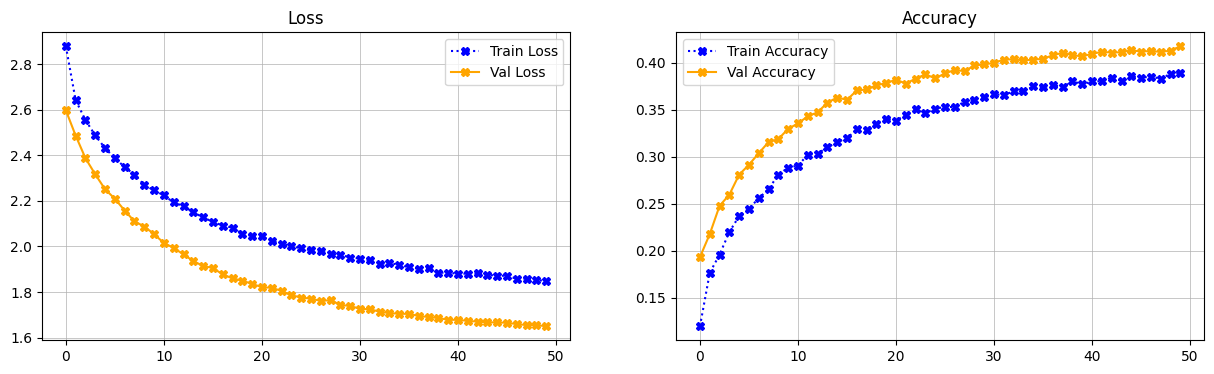

In [57]:
plot_loss_accuracy(history)

### ResNet V1

In [69]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

modelRNV1 = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(18, activation='softmax')
])

modelRNV1.build(input_shape=(None, 120, 120, 3))
modelRNV1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 32)                65568     
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 32)               

In [70]:
modelRNV1.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

historyRNV1 = modelRNV1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)

Epoch 1/50
1329/1329 [==============================] - 275s 206ms/step - loss: 2.7089 - accuracy: 0.1660 - val_loss: 2.4642 - val_accuracy: 0.2380
Epoch 2/50
1329/1329 [==============================] - 272s 205ms/step - loss: 2.5307 - accuracy: 0.2084 - val_loss: 2.4004 - val_accuracy: 0.2575
Epoch 3/50
1329/1329 [==============================] - 272s 205ms/step - loss: 2.4907 - accuracy: 0.2171 - val_loss: 2.3787 - val_accuracy: 0.2434
Epoch 4/50
1329/1329 [==============================] - 272s 205ms/step - loss: 2.4592 - accuracy: 0.2262 - val_loss: 2.3328 - val_accuracy: 0.2566
Epoch 5/50
1329/1329 [==============================] - 273s 205ms/step - loss: 2.4374 - accuracy: 0.2333 - val_loss: 2.2941 - val_accuracy: 0.2787
Epoch 6/50
1329/1329 [==============================] - 272s 205ms/step - loss: 2.4234 - accuracy: 0.2348 - val_loss: 2.3163 - val_accuracy: 0.2645
Epoch 7/50
1329/1329 [==============================] - 273s 205ms/step - loss: 2.4118 - accuracy: 0.2400 - val_

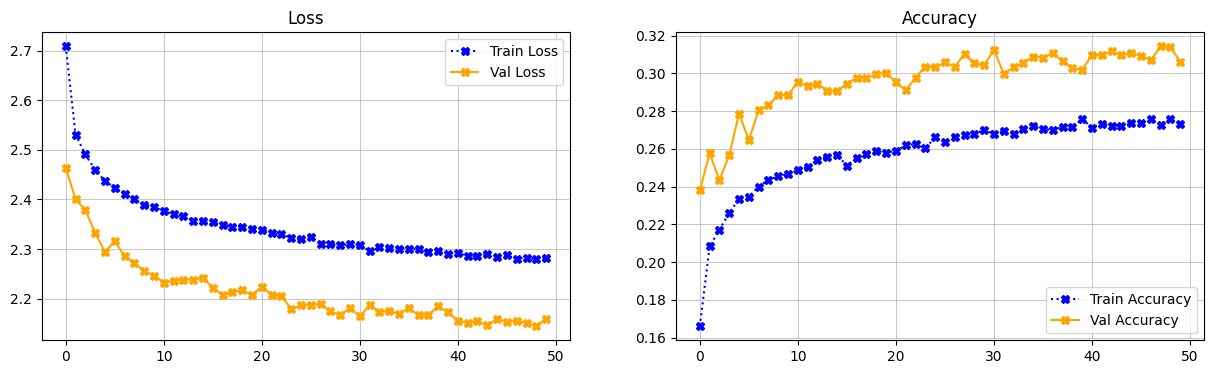

In [71]:
plot_loss_accuracy(historyRNV1)

### ResNet V2

In [76]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.1),
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

base_model.trainable = False

modelRNV2 = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.7),  # Increased dropout rate
    layers.Dense(18, activation='softmax')
])

modelRNV2.build(input_shape=(None, 120, 120, 3))
modelRNV2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 120, 120, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 128)               262272    
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128)             

In [77]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
) # taux d'apprentissage dynamique

modelRNV2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

historyRNV2 = modelRNV2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')]
)

Epoch 1/50
1329/1329 [==============================] - 312s 233ms/step - loss: 2.8368 - accuracy: 0.1671 - val_loss: 2.4335 - val_accuracy: 0.2413
Epoch 2/50
1329/1329 [==============================] - 341s 256ms/step - loss: 2.5157 - accuracy: 0.2112 - val_loss: 2.3712 - val_accuracy: 0.2556
Epoch 3/50
1329/1329 [==============================] - 318s 239ms/step - loss: 2.4787 - accuracy: 0.2214 - val_loss: 2.3461 - val_accuracy: 0.2634
Epoch 4/50
1329/1329 [==============================] - 323s 243ms/step - loss: 2.4470 - accuracy: 0.2301 - val_loss: 2.3169 - val_accuracy: 0.2726
Epoch 5/50
1329/1329 [==============================] - 323s 243ms/step - loss: 2.4307 - accuracy: 0.2342 - val_loss: 2.2833 - val_accuracy: 0.2819
Epoch 6/50
1329/1329 [==============================] - 332s 250ms/step - loss: 2.4086 - accuracy: 0.2398 - val_loss: 2.2643 - val_accuracy: 0.2780
Epoch 7/50
1329/1329 [==============================] - 332s 250ms/step - loss: 2.3992 - accuracy: 0.2456 - val_

KeyboardInterrupt: 

### ResNet V3 (doggos 101)

In [97]:
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3)) # Chargement du modèle de base ResNet50 pré-entraîné

base_model.trainable = False # Gèle les poids du modèle de base

model_doggo = tf.keras.Sequential([
    layers.Input((120, 120, 3)),
    layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    base_model, # base modèle ResNet50 ajouté en tant que couche
    layers.GlobalAveragePooling2D(), # pour réduire la dimensionnalité spatiale
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(18, activation='softmax')
])

def preprocess(img, label):
    img = resnet50.preprocess_input(img) # fonction preprocess_input de ResNet50 pour normaliser les images
    return img, label

es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1) # réduit le taux d'apprentissage si besoin

train_ds_prepro = train_ds.map(preprocess) # applique la fonction de prétraitement aux ensembles de données d'entraînement et de validation
validation_ds_prepro = val_ds.map(preprocess) # applique la fonction de prétraitement aux ensembles de données d'entraînement et de validation

model_doggo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_doggo = model_doggo.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=50,
                    callbacks=[es, rlr],
                    verbose=1)

Epoch 1/50
1329/1329 [==============================] - 300s 225ms/step - loss: 2.5155 - accuracy: 0.2127 - val_loss: 2.2954 - val_accuracy: 0.2686 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 300s 226ms/step - loss: 2.2887 - accuracy: 0.2640 - val_loss: 2.1797 - val_accuracy: 0.2955 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 294s 221ms/step - loss: 2.1842 - accuracy: 0.2932 - val_loss: 2.0909 - val_accuracy: 0.3248 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 296s 222ms/step - loss: 2.1104 - accuracy: 0.3081 - val_loss: 2.0143 - val_accuracy: 0.3360 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 299s 225ms/step - loss: 2.0550 - accuracy: 0.3223 - val_loss: 1.9603 - val_accuracy: 0.3481 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 298s 224ms/step - loss: 2.0087 - accuracy: 0.3328 - val_loss: 1.9571 - val_accuracy: 0.3476 - lr: 0.0010
Epoch 7/50
1329/1329 [============

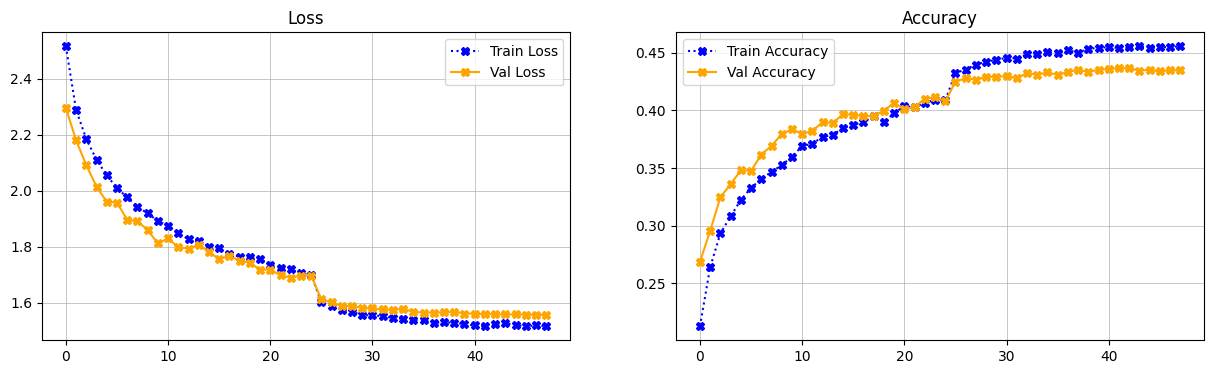

In [98]:
plot_loss_accuracy(history_doggo)

# Saving & loading the model

In [102]:
model_doggo.save("resnet_v3.keras")

In [103]:
from tensorflow.keras.models import load_model
loaded_model = load_model("resnet_v3.keras")

In [104]:
loaded_model

# Predictions

In [105]:
types

{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [112]:
# Grabs an image based on its URL, and resize it
def getImage(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    img = img.resize((120, 120))
    return img

# Takes an image and a model
def predictImage(url, model):
    # Get the image
    img = getImage(url)
    img = img_to_array(img)
    # Reshape the image
    img = img.reshape((120, 120, 3))
    # Preprocess the image
    img = model.preprocess_input(img)
    # Make predictions
    res = model.predict(img)
    
    # Get the top 3 predictions
    indexes = np.argsort(res)[0][-3:][::-1]  
    first = indexes[0]
    second = indexes[1]
    third = indexes[2]
    
    
    predicts = np.sort(res)[0][::-1][0:3]
    predict_first = round(predicts[0],2)
    predict_second = round(predicts[1],2)
    predict_third = round(predicts[2],2)
    
    class_names = types
    
    print(f"Top three types: {class_names[first]}, {class_names[second]}, {class_names[third]}")
    print(f"Top three probabilities = {predict_first*100} %, {predict_second*100} %, {predict_third*100} %")

In [113]:
grass = "https://archives.bulbagarden.net/media/upload/0/0c/0810Grookey.png"
firebug = "https://archives.bulbagarden.net/media/upload/8/83/0851Centiskorch.png"
grasspsychic = "https://archives.bulbagarden.net/media/upload/8/80/1010Iron_Leaves.png"
normalflying = "https://archives.bulbagarden.net/media/upload/b/b3/HOME0931W.png"

ValueError: cannot reshape array of size 57600 into shape (120,120,3)

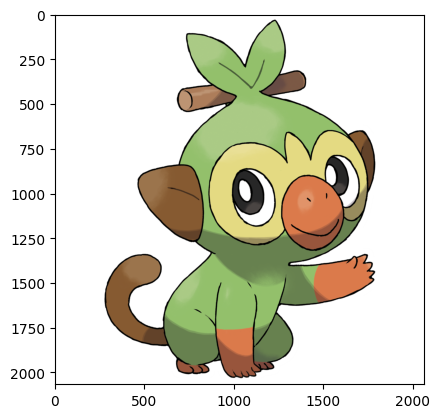

In [114]:
predictImage(grass, loaded_model)

In [ ]:
predictImage(firebug, loaded_model)

In [ ]:
predictImage(grasspsychic, loaded_model)

In [ ]:
predictImage(normalflying, loaded_model)